# Step 2: Exploratory Data Analysis

In the previous notebook I added a series of explanatory features from Google Earth Engine and other spatial sources to the wildfires dataset based on location and time. This notebook summarizes the EDA step, including exploring trends in wildfire size and occurence, distributions and statistical tests for explanatory continuous features, and visual EDA for explanatory categorical features.

In [1]:
# import packages
import numpy as np 
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

/Users/allankapoor/Documents/Springboard/wildfire_project/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [348]:
# import data
wildfires = pd.read_csv('Datasets/wildfires_withvars.csv', index_col='OBJECTID', low_memory=False)

## Distribution and Trends in Wildfire Size

In [236]:
#create binary small/large wildfire column
large_fire_classes = ['E','F','G']
wildfires['FIRE_SIZE_CLASS_binary'] = wildfires['FIRE_SIZE_CLASS'].apply(lambda t: 'Large' if t in large_fire_classes else 'Small')

In [24]:
size_count = wildfires.groupby('FIRE_SIZE_CLASS_binary')['FIRE_SIZE'].count()
size_count = pd.DataFrame(size_count).reset_index()
size_count

,FIRE_SIZE_CLASS_binary,FIRE_SIZE
0,Large,993
1,Small,82613


Very few wildfires are large.

In [25]:
size_sum = wildfires.groupby('FIRE_SIZE_CLASS_binary')['FIRE_SIZE'].sum()
size_sum = pd.DataFrame(size_sum).reset_index()
size_sum

,FIRE_SIZE_CLASS_binary,FIRE_SIZE
0,Large,6745308.750
1,Small,307201.202


However, the vast majority of area burned is caused by these few large wildfires. Let's see this in a chart:

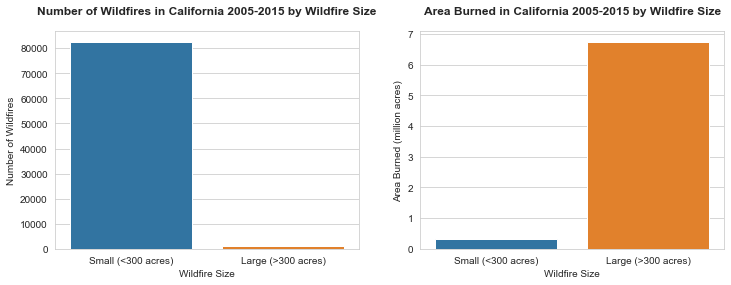

In [324]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4)) #sharey=True

#count plot of wildfires by size
sns.countplot(data=wildfires, x='FIRE_SIZE_CLASS_binary', ax=ax1, order=["Small", "Large"])

#bar plot of burned area by size
sns.barplot(data=size_sum, x='FIRE_SIZE_CLASS_binary', y='FIRE_SIZE', orient='v', ax=ax2, order=["Small", "Large"])

#set titles, labels
ax1.set_title('Number of Wildfires in California 2005-2015 by Wildfire Size', y=1.05, fontsize = 12, weight='bold')
ax2.set_title('Area Burned in California 2005-2015 by Wildfire Size', y=1.05, fontsize = 12, weight='bold')
ax2.set_yticks(np.arange(0,8000000, 1000000))
ax2.set_yticklabels(np.arange(0,8))
ax1.set_xlabel('Wildfire Size')
ax2.set_xlabel('Wildfire Size')
ax1.set_xticklabels(['Small (<300 acres)', 'Large (>300 acres)'])
ax2.set_xticklabels(['Small (<300 acres)', 'Large (>300 acres)'])
ax1.set_ylabel('Number of Wildfires')
ax2.set_ylabel('Area Burned (million acres)')

plt.show()

## Wildfire Frequency

In [69]:
# count number of wildfires discovered each day
wildfires['DISCOVERY_DT'] = pd.to_datetime(wildfires['DISCOVERY_DT'])
wildfires_byday = wildfires.groupby('DISCOVERY_DT').count()
wildfires_byday.rename(columns={'FIRE_SIZE':'No_Wildfires'}, inplace=True)
wildfires_byday = pd.DataFrame(wildfires_byday['No_Wildfires'])

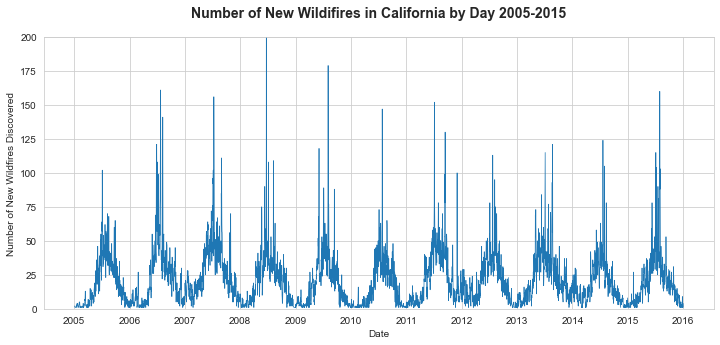

In [68]:
#plot timeseries of wildfires by day
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
sns.lineplot(data=wildfires_byday, x='DISCOVERY_DT', y='No_Wildfires', linewidth=0.7)

# set titles and labels
ax.set_title('Number of New Wildifires in California by Day 2005-2015', y=1.05, fontsize = 14, weight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of New Wildfires Discovered')
xticks = ax.get_xticks()
daterange = pd.date_range(start='2004', end='2016', freq='A')
ax.set_xticks(daterange)
ax.set_xticklabels(np.arange(2005,2017))
plt.ylim(0, 200)

plt.show()

Seasonal oscillations with peaks in the late summer. Many days on record with 100+ wildfires. One outlier day in 1008.

What is the average number of wildfires discovered per day in August (peak wildfire season)?

In [72]:
wildfires_byday[wildfires_byday.index.month == 8].No_Wildfires.mean()

38.44574780058651

What is the maximum number of wildfires discovered in a single day?

In [73]:
wildfires_byday.max()

No_Wildfires    551
dtype: int64

What date did that occur?

In [135]:
wildfires_byday.idxmax()

No_Wildfires   2008-06-21
dtype: datetime64[ns]

Let's see that on a map. Where did all these wildfires occur?

In [99]:
# create wildfired geodataframe for spatial display
wildfires_gdf = gpd.GeoDataFrame(wildfires, geometry=gpd.points_from_xy(wildfires.LONGITUDE, wildfires.LATITUDE), crs='EPSG:4269')

# load counties shapefile
counties_gdf = gpd.read_file('Datasets/CA_Counties/CA_Counties_TIGER2016.shp')

# convert CRS of counties to NAD83 
counties_gdf = counties_gdf.to_crs(4269)

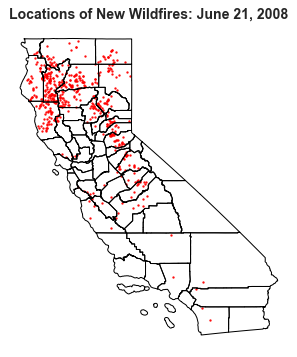

In [134]:
# filter for wildfires occuring on 2008-06-21
max_day = wildfires_gdf[wildfires_gdf.DISCOVERY_DT == '2008-06-21']

#plot locations of wildfires discovered on Jun 21 2008
sns.set_style("white")
fig, ax = plt.subplots(figsize = (8,6))
max_day.plot(color='r', markersize=2, alpha=0.8, ax=ax)
counties_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)
ax.axis('off')
ax.set_title('Locations of New Wildfires: June 21, 2008', fontsize = 14, weight='bold')

plt.show()

## Trends by Location

We'll use county as a unit of analysis

In [210]:
#generate summary statistics by county

# group by based on county, sum
wfs_county_sum = wildfires.groupby('COUNTY_NAME').sum('FIRE_SIZE')['FIRE_SIZE'].reset_index()

# group by based on county, count
wfs_county_count = wildfires.groupby('COUNTY_NAME').count()['FIRE_SIZE'].reset_index().rename(columns={'FIRE_SIZE':'NO_WFS'})

#group by based on county, mean
wfs_county_av = wildfires.groupby('COUNTY_NAME').mean('FIRE_SIZE')['FIRE_SIZE'].reset_index().rename(columns={'FIRE_SIZE':'AV_SIZE'})

#join to county geodataframe
county_merge = counties_gdf[['NAME','geometry']].merge(wfs_county_sum, how='left', left_on='NAME', right_on='COUNTY_NAME')
county_merge = county_merge.merge(wfs_county_count, how='left', left_on='NAME', right_on='COUNTY_NAME')
county_merge = county_merge.merge(wfs_county_av, how='left', left_on='NAME', right_on='COUNTY_NAME')

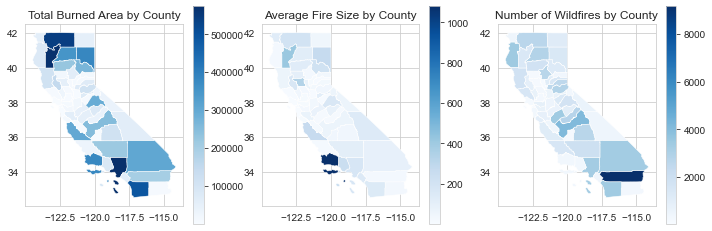

In [228]:
#plot Choropleth maps (by county)
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize = (12,4))

county_merge.plot(column='FIRE_SIZE', ax=ax1, legend=True, cmap='Blues', linewidth = 0.5)
ax1.set_title('Total Burned Area by County')

county_merge.plot(column='AV_SIZE', ax=ax2, legend=True, cmap='Blues', linewidth = 0.5)
ax2.set_title('Average Fire Size by County')

county_merge.plot(column='NO_WFS', ax=ax3, legend=True, cmap='Blues', linewidth = 0.5)
ax3.set_title('Number of Wildfires by County');

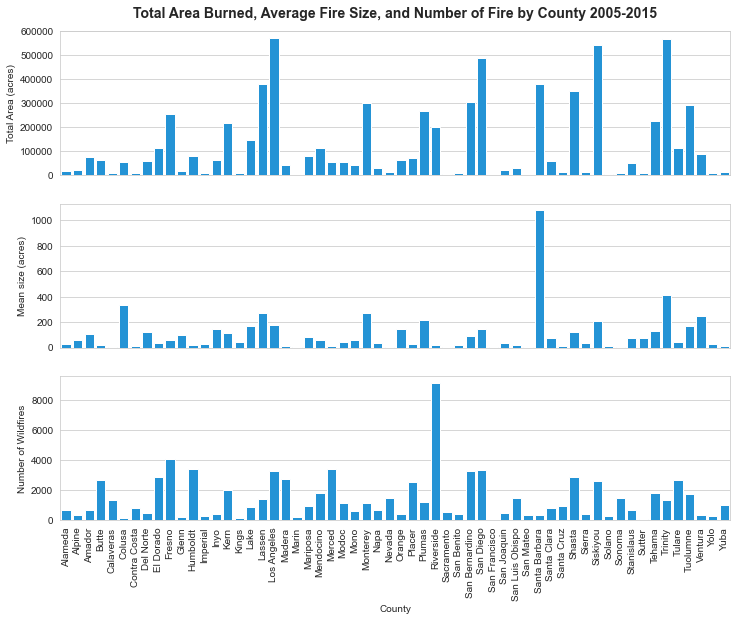

In [227]:
# bar plots of summary stats by county
sns.set_style("whitegrid")
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize = (12,9))

county_merge.sort_values('COUNTY_NAME', inplace=True)
blue='#069AF3'

sns.barplot(data=county_merge, x='COUNTY_NAME', y='FIRE_SIZE', orient='v', ax=ax1, color=blue)
ax1.set_title('Total Area Burned, Average Fire Size, and Number of Fire by County 2005-2015', y=1.05, fontsize = 14, weight='bold' )
ax1.set_ylabel('Total Area (acres)')
ax1.set(xlabel=None, xticklabels=[])

sns.barplot(data=county_merge, x='COUNTY_NAME', y='AV_SIZE', orient='v', ax=ax2, color=blue)
#ax2.set_title('Average Fire Size by County')
ax2.set_ylabel('Mean size (acres)')
ax2.set(xlabel=None, xticklabels=[])

sns.barplot(data=county_merge, x='COUNTY_NAME', y='NO_WFS', orient='v', ax=ax3, color=blue)
#ax3.set_title('Number of Wildfires by County')
ax3.set_ylabel('Number of Wildfires')
ax3.set_xlabel('County')

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.show();

## Exploring Wildfire Size (Continuous)

In [294]:
# wildfire size - summary statistics
wildfires['FIRE_SIZE'].describe()

count     83606.000000
mean         84.354113
std        2516.983897
min           0.001000
25%           0.100000
50%           0.250000
75%           1.000000
max      315578.800000
Name: FIRE_SIZE, dtype: float64

In [296]:
# wildfire size - 99th percentile
np.percentile(wildfires['FIRE_SIZE'],[99])[0]

400.0

In [322]:
# wildfires <1 acre
count_1acre = (wildfires['FIRE_SIZE']<1).sum()
prop_1acre = count_1acre/wildfires.count()[0]*100

print(f'{round(count_1acre,2)} wildfires ({round(prop_1acre,2)}%) are <1 acre')

52431 wildfires (62.71%) are <1 acre


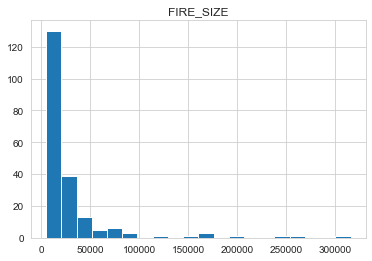

In [326]:
# Histogram of the size of Class G wildfires (largest category)
wildfires[wildfires['FIRE_SIZE_CLASS']=='G'][['FIRE_NAME','DISCOVERY_DT','COUNTY_NAME','FIRE_SIZE']].sort_values('FIRE_SIZE', ascending=False).hist(bins=20);

In [310]:
# table of largest wildfires (>100,000 acres)
wildfires[wildfires['FIRE_SIZE']>100000][['FIRE_NAME','DISCOVERY_DT','COUNTY_NAME','FIRE_SIZE']].sort_values('FIRE_SIZE', ascending=False)

,FIRE_NAME,DISCOVERY_DT,COUNTY_NAME,FIRE_SIZE
OBJECTID,,,,
1572843,RUSH,2012-08-12,Lassen,315578.8
1641751,RIM,2013-08-17,Tuolumne,255858.0
24835,ZACA,2007-07-04,Santa Barbara,240207.0
26364,WITCH,2007-10-21,San Diego,197990.0
27902,BASIN COMPLEX,2008-06-21,Monterey,162818.0
14836,DAY,2006-09-04,Los Angeles,162702.0
41297,STATION,2009-08-26,Los Angeles,160371.0
1793233,ROUGH,2015-07-31,Fresno,151623.0
1722920,FRYING PAN,2014-08-11,Siskiyou,115279.2


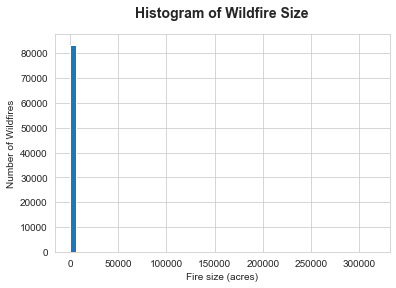

In [289]:
#plot histogram of continuous wildfire size feature
wildfires['FIRE_SIZE'].hist(bins=50)
plt.xlabel('Fire size (acres)')
plt.ylabel('Number of Wildfires')
plt.title('Histogram of Wildfire Size', y=1.05, fontsize=14, weight='bold');

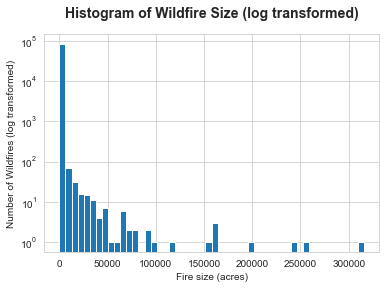

In [288]:
#plot log transformed histogram of continuous wildfire size feature
wildfires['FIRE_SIZE'].hist(bins=50).set_yscale('log')
plt.xlabel('Fire size (acres)')
plt.ylabel('Number of Wildfires (log transformed)')
plt.title('Histogram of Wildfire Size (log transformed)', y=1.05, fontsize=14, weight='bold');

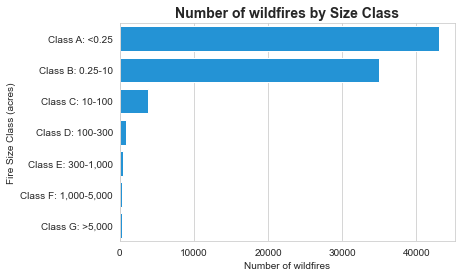

In [332]:
#count plot of wildfires by size class
fig = sns.countplot(y=wildfires['FIRE_SIZE_CLASS'], orient='v', order=['A','B','C','D','E','F','F'], color=blue)
fig.set_yticklabels(['Class A: <0.25','Class B: 0.25-10','Class C: 10-100','Class D: 100-300','Class E: 300-1,000','Class F: 1,000-5,000','Class G: >5,000'])
plt.xlabel('Number of wildfires')
plt.ylabel('Fire Size Class (acres)')
plt.title('Number of wildfires by Size Class', fontsize=14, weight='bold');

## Wildfire Size Category vs Continuous Explanatory Features

Looking at the relationship (and stataistiucal significance) between each explanatory variable and wildfire size.

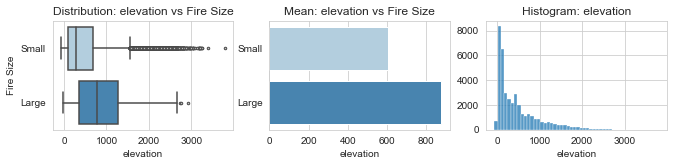

Two-tailed T test
t: -13.2816
p: 0.0


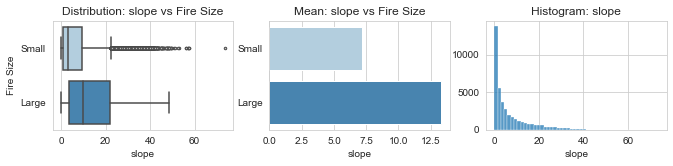

Two-tailed T test
t: -17.3167
p: 0.0


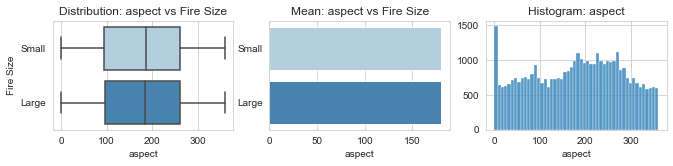

Two-tailed T test
t: -0.2021
p: 0.8398


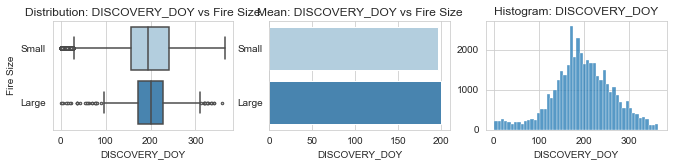

Two-tailed T test
t: -2.1209
p: 0.0342


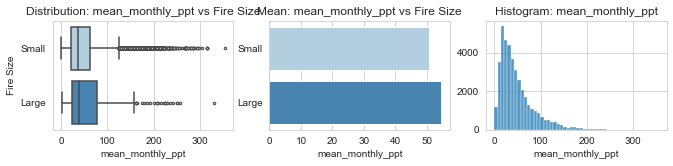

Two-tailed T test
t: -2.9386
p: 0.0034


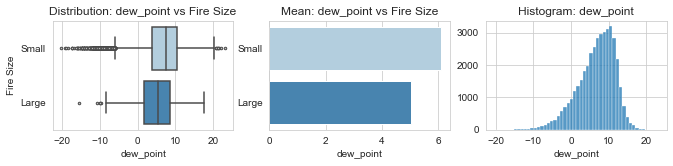

Two-tailed T test
t: 6.8842
p: 0.0


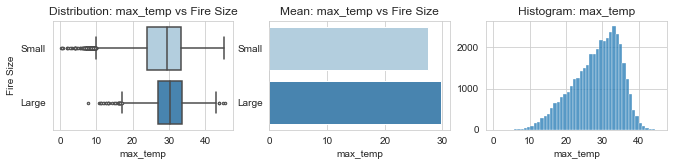

Two-tailed T test
t: -13.2021
p: 0.0


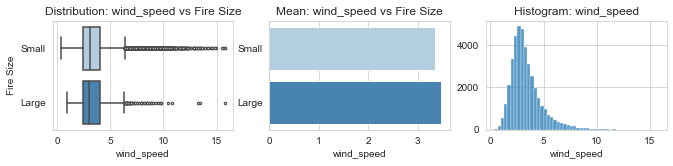

Two-tailed T test
t: -2.6042
p: 0.0093


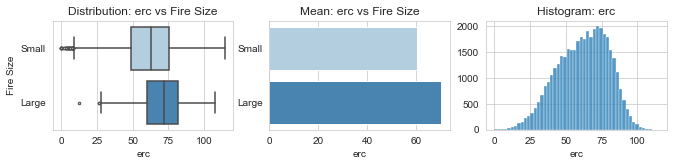

Two-tailed T test
t: -20.6889
p: 0.0


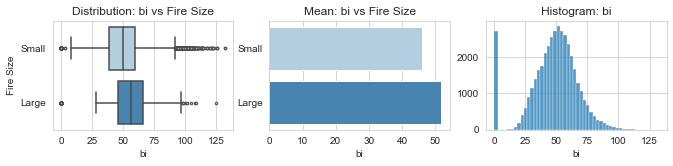

Two-tailed T test
t: -7.5722
p: 0.0


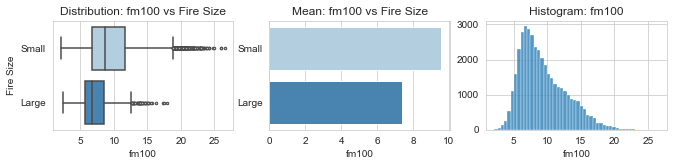

Two-tailed T test
t: 27.1172
p: 0.0


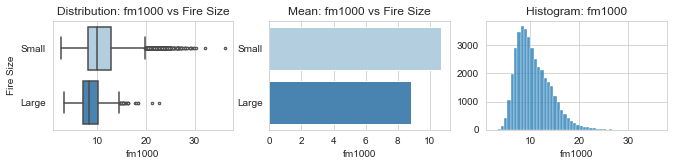

Two-tailed T test
t: 23.7555
p: 0.0


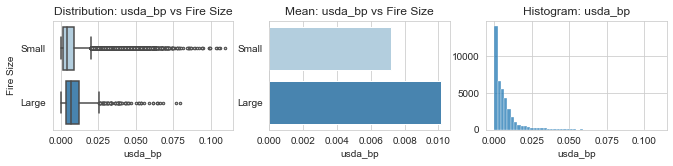

Two-tailed T test
t: -8.2959
p: 0.0


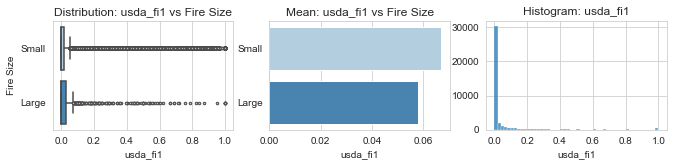

Two-tailed T test
t: 1.9139
p: 0.0559


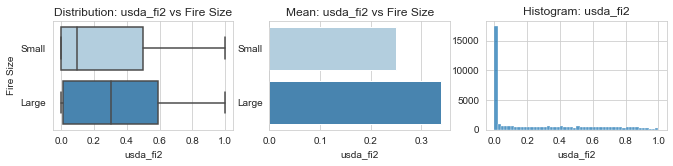

Two-tailed T test
t: -9.2578
p: 0.0


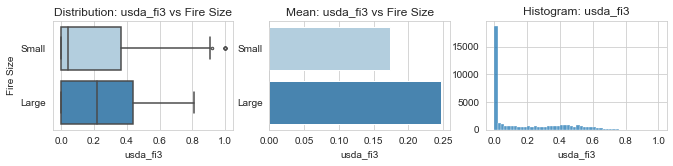

Two-tailed T test
t: -10.3161
p: 0.0


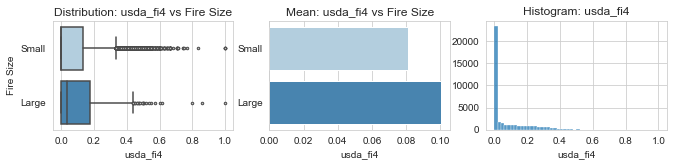

Two-tailed T test
t: -4.4639
p: 0.0


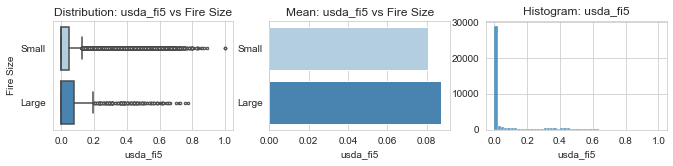

Two-tailed T test
t: -1.2976
p: 0.1947


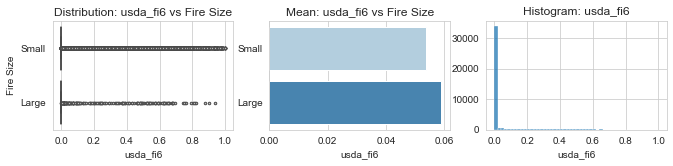

Two-tailed T test
t: -1.0156
p: 0.31


In [345]:
# list of continuous features + target variab;e
cols= ['FIRE_SIZE_CLASS_binary','elevation', 'slope', 'aspect', 'DISCOVERY_DOY','mean_monthly_ppt',
       'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000','usda_bp', 'usda_fi1',
       'usda_fi2', 'usda_fi3', 'usda_fi4', 'usda_fi5', 'usda_fi6']

# create dataframe for holding statistical test results
ttest_df = pd.DataFrame(data=cols[1:],columns=['Feature'])
ttest_df.set_index('Feature', inplace=True)
ttest_df['T-Score']=np.nan
ttest_df['P Value']=np.nan

# filter out small wildfires
df = wildfires[wildfires['FIRE_SIZE_CLASS'] != 'A'][cols]

# style for boxplot outlier marks  
flierprops = dict(markerfacecolor='0.75', markersize=5, linestyle='none', marker='.')

# for each continuous feature: plot boxplot (by size), bar plot of means (by size), and histogram
# two-tailed t test, print t and p
for i, col in enumerate(df.columns[1:]):
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(11, 2))
    
    # boxplot 
    sns.boxplot(x=col, y='FIRE_SIZE_CLASS_binary', data=df, palette='Blues', flierprops=flierprops, ax=ax1, order=['Small','Large'])

    # bar plot of means
    mean_table = wildfires.groupby('FIRE_SIZE_CLASS_binary')[col].mean()
    sns.barplot(y=mean_table.index, x=mean_table, palette='Blues', ax=ax2,  order=['Small','Large'])
    
    # histogram
    sns.histplot(x=col, data=df, ax=ax3, bins=50)
    
    # set titles, labels
    ax1.set_title('Distribution: '+col+' vs Fire Size')
    ax1.set_ylabel('Fire Size')
    ax2.set_title('Mean: '+col+' vs Fire Size')
    ax2.set_ylabel('')
    ax3.set_title('Histogram: '+col)
    ax3.set_ylabel('')
    
    plt.show()
    
    #statistical test
    small = wildfires[wildfires['FIRE_SIZE_CLASS_binary']=='Small']
    large = wildfires[wildfires['FIRE_SIZE_CLASS_binary']=='Large']
    t, p = stats.ttest_ind(small[col], large[col], equal_var=False)
    t = round(t,4)
    p = round(p,4)
    ttest_df.loc[col,'T-Score'] = t
    ttest_df.loc[col,'P Value'] = p
    
    print('Two-tailed T test')
    print(f't: {t}')
    print(f'p: {p}')

In [347]:
#display and save results of statistical tests
ttest_df.to_csv('ttest_results.csv')
ttest_df

,T-Score,P Value
Feature,,
elevation,-13.2816,0.0000
slope,-17.3167,0.0000
aspect,-0.2021,0.8398
DISCOVERY_DOY,-2.1209,0.0342
mean_monthly_ppt,-2.9386,0.0034
dew_point,6.8842,0.0000
max_temp,-13.2021,0.0000
wind_speed,-2.6042,0.0093
erc,-20.6889,0.0000


## Wildfire Size Category vs Categorical Explanatory Features

In [379]:
categoricals = {'WHR10NAME':'Vegetation Type','NA_L2NAME':'Level II Ecoregion', 'US_L3NAME':'Level III Ecoregion'}

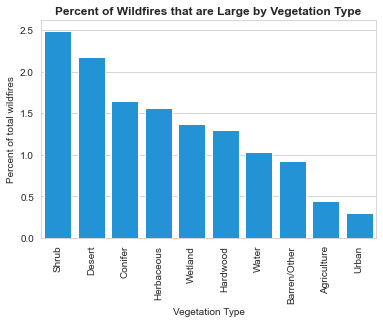

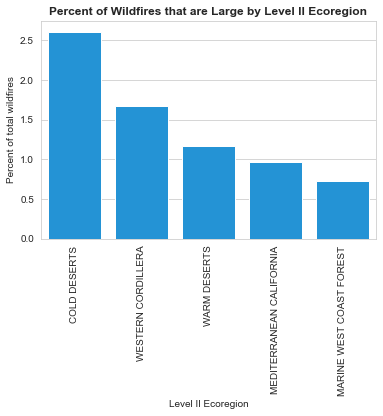

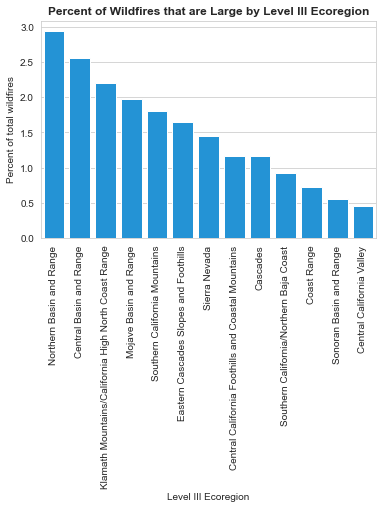

In [380]:
# plot proportion of wildfires that are large for each categorical variable's categories 
for cat, label in categoricals.items():
    crosstab = pd.crosstab(wildfires['FIRE_SIZE_CLASS_binary'], wildfires[cat]).T
    crosstab['Pcnt_Large'] = round(crosstab['Large']/(crosstab['Large']+crosstab['Small'])*100,2)
    crosstab.sort_values('Pcnt_Large', ascending=False, inplace=True)
    sns.barplot(data=crosstab, x=crosstab.index, y='Pcnt_Large', color=blue)
    locs, labels = plt.xticks()
    plt.ylabel('Percent of total wildfires')
    plt.xlabel(label)
    plt.title(f'Percent of Wildfires that are Large by {label}', weight='bold')
    plt.setp(labels, rotation=90)
    plt.show()

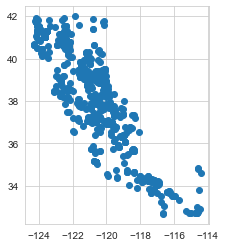

In [384]:
#plotting wildfires that recieved vegetation type = water
#looks like these are where GPS coordinates fall near rivers/lakes (vegetation type is a grid so there is some spatial inaccuracy)
wildfires_gdf[wildfires_gdf['WHR10NAME']=='Water'].plot();